In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans



# 1. Load Data


In [2]:
file_path = '../data/raw/online_retail_II.xlsx'
print("Loading data... (this may take a moment)")
df = pd.read_excel(file_path, sheet_name='Year 2009-2010')



Loading data... (this may take a moment)


# 2. Cleaning Pipeline


In [3]:
print("Cleaning data...")
df_clean = df.dropna(subset=['Customer ID']).copy()


Cleaning data...


# Ensure positive quantity and price


In [4]:
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['Price'] > 0)]


# Type conversion


In [5]:

df_clean['Customer ID'] = df_clean['Customer ID'].astype(int).astype(str)
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])



# Create Total Price (Revenue per line item)


In [6]:
df_clean['Total Price'] = df_clean['Quantity'] * df_clean['Price']

print(f"Cleaned Data Rows: {df_clean.shape[0]}")
df_clean.head()

Cleaned Data Rows: 407664


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total Price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


# 1. Calculate Reference Date


In [7]:
reference_date = df_clean['InvoiceDate'].max() + pd.DateOffset(days=1)


# 2. Aggregation (The RFM Table)

In [8]:


rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days, # Recency
    'Invoice': 'nunique',       # Frequency
    'Total Price': 'sum'        # Monetary
}).reset_index()


# 3. Rename Columns (Fixing the typo here!)


In [9]:

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Total Price': 'Monetary'   
}, inplace=True)


# 4. Remove zeros or negatives for Log Transformation stability
# (Log of 0 or negative numbers crashes the math)

In [10]:


rfm = rfm[rfm['Monetary'] > 0]
rfm = rfm[rfm['Frequency'] > 0]

print(f"RFM Shape: {rfm.shape}")
rfm.head()

RFM Shape: (4312, 4)


,Customer ID,Recency,Frequency,Monetary
0,12346,165,11,372.86
1,12347,3,2,1323.32
2,12348,74,1,222.16
3,12349,43,3,2671.14
4,12351,11,1,300.93


# 1. Log Transformation (Handling skewed data)
# Use 'Monetary' (Correct spelling)

In [11]:

rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])



# 2. Scaling

In [12]:

scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_log)



# 3. Elbow Method

In [13]:

inertia = []
range_n_clusters = range(1, 11)

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_normalized)
    inertia.append(kmeans.inertia_)



# 4. Plot (Fixed plt.figure issue)

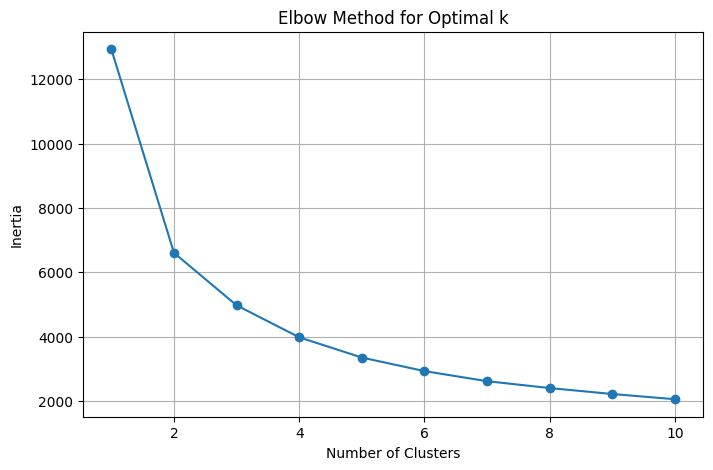

In [14]:

plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 1. Train Model with k=3

In [15]:

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_normalized)


# 2. Interpret Segments (Calculate means per cluster)


In [16]:

cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print("Cluster Centroids (Interpret this!):")
print(cluster_summary)


Cluster Centroids (Interpret this!):
   Cluster     Recency  Frequency     Monetary
0        0   54.355077   3.428815  1300.115946
1        1   17.919951  13.427340  7360.172990
2        2  162.782959   1.303972   324.374435



# 3. Dynamic Logic to define Segments
# We sort clusters by 'Monetary' value to define who is who.
# The Cluster with HIGHEST Monetary mean is 'Champions'
# The Cluster with LOWEST Monetary mean is 'Hibernating'

In [17]:

def get_segment_dict(summary_df):
    summary_df = summary_df.sort_values(by='Monetary', ascending=True)
    summary_df['Segment_Name'] = ['Hibernating', 'Potential Loyalists', 'Champions']
    # Create a dictionary {ClusterID: Name}
    return dict(zip(summary_df['Cluster'], summary_df['Segment_Name']))

segment_map = get_segment_dict(cluster_summary)
print("\nGenerated Mapping based on Data:", segment_map)

# 4. Apply the mapping
rfm['Segment'] = rfm['Cluster'].map(segment_map)

print(rfm['Segment'].value_counts())


Generated Mapping based on Data: {2: 'Hibernating', 0: 'Potential Loyalists', 1: 'Champions'}
Segment
Potential Loyalists    1763
Hibernating            1737
Champions               812
Name: count, dtype: int64


# Calculate Log columns strictly for plotting


In [18]:
rfm['Recency_Log'] = np.log1p(rfm['Recency'])
rfm['Frequency_Log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_Log'] = np.log1p(rfm['Monetary'])


# 3D Scatter Plot


In [19]:

fig = px.scatter_3d(rfm, 
                    x='Recency_Log', 
                    y='Frequency_Log', 
                    z='Monetary_Log',
                    color='Segment', 
                    opacity=0.7,
                    title='3D Customer Segments (Log Scaled)',
                    labels={
                        'Recency_Log': 'Recency (Log)', 
                        'Frequency_Log': 'Frequency (Log)', 
                        'Monetary_Log': 'Monetary (Log)'
                    },
                    color_discrete_map={
                        'Champions': 'green', 
                        'Potential Loyalists': 'blue', 
                        'Hibernating': 'red'}
                   )


# Ensure the colors apply even if map naming differs slightly


In [20]:

fig.update_layout(scene = dict(
                    xaxis_title='Recency (Days)',
                    yaxis_title='Frequency (Count)',
                    zaxis_title='Monetary ($)'))
fig.show()

# Save the segmented data for the next step

In [21]:

rfm.to_csv('../data/processed/rfm_segments.csv', index=False)
print("Segments saved successfully.")

Segments saved successfully.
